In [1]:
import pandas as pd

In [2]:
## KAGGLE

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
# train = pd.read_csv('../input/sentimen-restoran/preprocessed_train.csv')
# test = pd.read_csv('../input/sentimen-restoran/preprocessed_test.csv')

In [4]:
train = pd.read_csv('data/preprocessed_train.csv')
test = pd.read_csv('data/preprocessed_test.csv')

In [5]:
sentiment_to_id = {'positive': 1, 'negative': 0}
id_to_sentiment = {1: 'positive', 0: 'negative'}

In [6]:
train.head()

text  sentiment  \
0  Saya makan di sini dengan menggunakan voucher ...          0   
1  Mas indosat buat main game enemy has been slai...          0   
2  Trus sy percuma dong update no hp terbaru ke c...          0   
3  jika kita pilih dia maka akan ada lebih dari 3...          0   
4  Dikarenakan adik saya suka dengan restoran ini...          0   

                                        cleaned_text  \
0  saya makan di sini dengan menggunakan voucher ...   
1  mas indosat buat main game enemy has been slai...   
2  terus saya percuma dong update nomor hp terbar...   
3  jika kita pilih dia maka akan ada lebih dari k...   
4  dikarenakan adik saya suka dengan restoran ini...   

                                    barasa_senti_val  barasa_total_pos_word  \
0  [('saya', [0.0, 0.0]), ('makan', [0.0410714285...                     19   
1  [('mas', [0.0, 0.0625]), ('buat', [0.0, 0.0]),...                      7   
2  [('terus', [0.06, 0.045]), ('saya', [0.0, 0.0]...                      6   
3  [('jika', [0.0, 0.0]), ('kita', [0.0, 0.0]), (...                      4   
4  [('adik', [0.0, 0.0]), ('saya', [0.0, 0.0]), (...                     21   

   barasa_total_neg_word  barasa_mean_pos_sentiment_val  \
0                     19                       0.078069   
1                     11                       0.095732   
2                      5                       0.087889   
3                      4                       0.040634   
4                     26                       0.119401   

   barasa_mean_neg_sentiment_val  \
0                       0.149732   
1                       0.136639   
2                       0.104795   
3                       0.085928   
4                       0.149148   

                                          translated  \
0  I eat here using the disdus voucher for the cu...   
1  Sir, Indosat for playing the game, the enemy h...   
2  then I am useless, please update the latest ce...   
3  if we choose him then there will be more than ...   
4  because my sister likes this restaurant, I fin...   

                                     trans_senti_val  trans_total_pos_word  \
0  [('eat', [0.041666666666666664, 0.0]), ('here'...                    18   
1  [('Sir', [0.0, 0.0]), ('playing', [0.039285714...                     8   
2  [('then', [0.0, 0.0]), ('am', [0.0288461538461...                    10   
3  [('choose', [0.0, 0.0]), ('then', [0.0, 0.0]),...                     2   
4  [('sister', [0.03125, 0.03125]), ('likes', [0....                    24   

   trans_total_neg_word  trans_mean_pos_sentiment_val  \
0                    14                      0.049165   
1                    12                      0.102066   
2                     9                      0.068739   
3                     3                      0.028846   
4                    27                      0.094519   

   trans_mean_neg_sentiment_val  
0                      0.075428  
1                      0.133502  
2                      0.129534  
3                      0.096154  
4                      0.077969

### Feature Selection

In [7]:
X_train = train['cleaned_text']

X_train_sent_barasa = train[['barasa_total_pos_word', 'barasa_total_neg_word', \
                            'barasa_mean_pos_sentiment_val', 'barasa_mean_neg_sentiment_val']]

# X_train_text_sent_barasa = X_train_sent_barasa.copy() + BOW vector of cleaned text

X_train_sent_trans = train[['trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val']]

# X_train_text_sent_trans = X_train_sent_trans.copy()+ BOW vector of cleaned text

y_train = train['sentiment']

In [8]:
X_test = test['cleaned_text']

X_test_sent_barasa = test[['barasa_total_pos_word', 'barasa_total_neg_word', \
                            'barasa_mean_pos_sentiment_val', 'barasa_mean_neg_sentiment_val']]

# X_test_text_sent_barasa = X_test_sent_barasa.copy() + BOW vector of cleaned text

X_test_sent_trans = test[['trans_total_pos_word', 'trans_total_neg_word', \
                            'trans_mean_pos_sentiment_val', 'trans_mean_neg_sentiment_val']]

# X_test_text_sent_trans = X_test_sent_trans.copy()+ BOW vector of cleaned text

y_test = test['sentiment']

### CBOW using gensim.word2vec

In [9]:
from gensim.models import word2vec

In [10]:
sentences = []

for text in train['cleaned_text']:
    sentences.append(text.split())

In [11]:
# Initializing the train model
print("Training model....")
# CBOW, because when training word2vec model not explicitly using parameter sg=1 (skip-gram=1)
model_w2v = word2vec.Word2Vec(sentences)

Training model....


In [12]:
# To make the model memory efficient
model_w2v.init_sims(replace=True)

#### create train & test vector

In [13]:
#Converting Index2Word which is a list to a set for better speed in the execution.
index2word_set = set(model_w2v.wv.index2word)

In [14]:
# Function to average all word vectors in a text
def featureVecMethod(words, model_w2v, num_features, w2v_index2word=index2word_set):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features, dtype="float32")
    nwords = 0
    
    for word in  words:
        if word in w2v_index2word:
            nwords = nwords + 1
            featureVec = np.add(featureVec, model_w2v.wv[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    
    return featureVec

In [15]:
import numpy as np

In [16]:
# Function for calculating the average feature vector
# texts: text from all row
def getAvgFeatureVecs(texts, model_w2v, num_features, w2v_index2word=index2word_set):
    counter = 0
    FeatureVecs = np.zeros((len(texts), num_features), dtype="float32")
    
    # for each row
    for text in texts:
        FeatureVecs[counter] = featureVecMethod(text, model_w2v, num_features, w2v_index2word)
        counter = counter+1
        
    return FeatureVecs

In [17]:
num_features = model_w2v.wv.vectors.shape[1]

In [18]:
trainDataVecs = getAvgFeatureVecs(train['cleaned_text'], model_w2v, num_features)
testDataVecs = getAvgFeatureVecs(test['cleaned_text'], model_w2v, num_features)

In [19]:
trainDataVecs.shape

(1780, 100)

In [20]:
type(trainDataVecs)

numpy.ndarray

In [21]:
X_train = trainDataVecs
X_train_text_sent_barasa = np.concatenate((trainDataVecs, X_train_sent_barasa), axis=1)
X_train_text_sent_trans = np.concatenate((trainDataVecs, X_train_sent_trans), axis=1)

X_test = testDataVecs
X_test_text_sent_barasa = np.concatenate((testDataVecs, X_test_sent_barasa), axis=1)
X_test_text_sent_trans = np.concatenate((testDataVecs, X_test_sent_trans), axis=1)

### Train

In [22]:
# Library for Deep Learning
from keras import backend as K

Using TensorFlow backend.


In [23]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### set random seed

In [24]:
import tensorflow as tf

In [25]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [26]:
import random
# import numpy as np

#### 1. Base Model (using cleaned_text only)

In [27]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [28]:
X_train.shape

(1780, 100)

In [29]:
type(X_train)

numpy.ndarray

In [30]:
# Reshaping X_train & X_test
X_train = X_train[:, :, None]
X_test = X_test[:, :, None]

In [31]:
X_train.shape

(1780, 100, 1)

In [32]:
base_model = Sequential()
base_model.add(LSTM(10, dropout=0.2, input_shape=X_train.shape[1:]))
base_model.add(layers.Dense(8, activation='relu'))
base_model.add(Dropout(0.2))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [33]:
base_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [34]:
EPOCHS = 10
BATCH_SIZE = 1024

history = base_model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1246 samples, validate on 534 samples
Epoch 1/10
1246/1246 [==============================] - 1s 577us/step - loss: 0.6932 - accuracy: 0.4791 - f1_m: 0.3322 - val_loss: 0.6907 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 2/10
1246/1246 [==============================] - 0s 143us/step - loss: 0.6930 - accuracy: 0.5345 - f1_m: 0.6895 - val_loss: 0.6873 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 3/10
1246/1246 [==============================] - 0s 146us/step - loss: 0.6927 - accuracy: 0.5345 - f1_m: 0.6957 - val_loss: 0.6835 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 4/10
1246/1246 [==============================] - 0s 145us/step - loss: 0.6925 - accuracy: 0.5345 - f1_m: 0.6986 - val_loss: 0.6796 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 5/10
1246/1246 [==============================] - 0s 173us/step - loss: 0.6923 - accuracy: 0.5345 - f1_m: 0.6941 - val_loss: 0.6755 - val_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 6/10
1246/1246 [==============================]

In [35]:
def save_model(model, FILE_NAME):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open(FILE_NAME +'.yaml', "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights(FILE_NAME +'.h5')
    print("Saved model to disk")

In [36]:
save_model(base_model, 'model/LSTM cbow_base')

Saved model to disk


In [37]:
history.history

{'val_loss': [0.6907272934913635,
  0.6872676610946655,
  0.6835440397262573,
  0.679580807685852,
  0.6754714250564575,
  0.6711651682853699,
  0.6667048335075378,
  0.6622584462165833,
  0.6586580276489258,
  0.6553977131843567],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_f1_m': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'loss': [0.6932415091589595,
  0.6929610831779615,
  0.692716922270161,
  0.6924600333310245,
  0.6922931461617422,
  0.6918980615096911,
  0.6916481731982713,
  0.6915372395783328,
  0.6921579511552141,
  0.6911434676635706],
 'accuracy': [0.47913322,
  0.53451043,
  0.53451043,
  0.53451043,
  0.53451043,
  0.53451043,
  0.53451043,
  0.53451043,
  0.53451043,
  0.53451043],
 'f1_m': [0.33222753,
  0.6895395,
  0.6956593,
  0.6986478,
  0.6941473,
  0.7001246,
  0.7183068,
  0.6910875,
  0.6879792,
  0.6926234]}

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

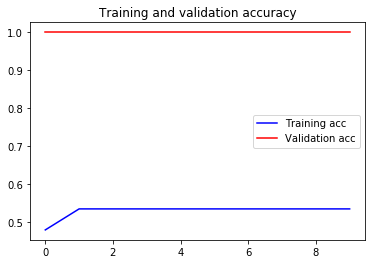

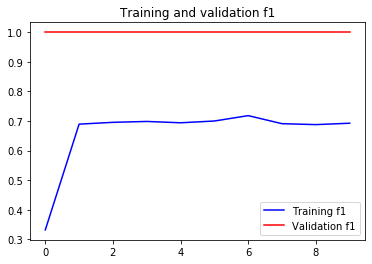

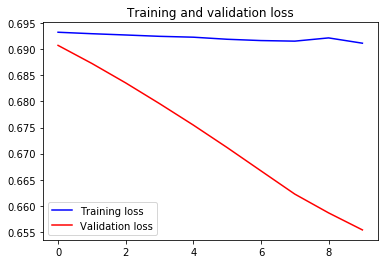

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [40]:
score = base_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 53us/step

f1: 0.786885142326355
accuracy: 0.6486486196517944
LOSS: 0.6824448704719543


In [41]:
# predict probabilities for val set
y_pred_probs = base_model.predict(X_test, verbose=0)
# predict crisp classes for val set
y_pred = base_model.predict_classes(X_test, verbose=0)

In [42]:
y_pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [43]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [45]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.648649
Precision: 0.648649
Recall: 1.000000
F1 score: 0.786885
Kappa score: 0.000000


In [46]:
from sklearn.metrics import confusion_matrix

Text(0.5, 15.0, 'Predicted')

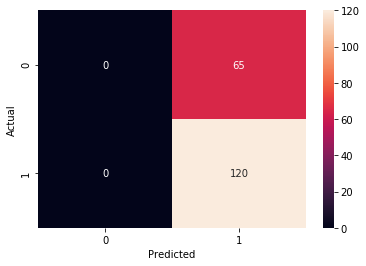

In [47]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 2. Barasa Sentiment Model

In [48]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [49]:
X_train_sent_barasa.shape

(1780, 4)

In [50]:
type(X_train_sent_barasa)

pandas.core.frame.DataFrame

In [51]:
X_train_sent_barasa = X_train_sent_barasa.to_numpy()
X_test_sent_barasa = X_test_sent_barasa.to_numpy()

In [52]:
type(X_train_sent_barasa)

numpy.ndarray

In [53]:
X_train_sent_barasa.shape

(1780, 4)

In [54]:
# Reshaping X_train & X_test
X_train_sent_barasa = X_train_sent_barasa[:, :, None]
X_test_sent_barasa = X_test_sent_barasa[:, :, None]

In [55]:
X_train_sent_barasa.shape

(1780, 4, 1)

In [56]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, input_shape=X_train_sent_barasa.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [58]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train_sent_barasa, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1246 samples, validate on 534 samples
Epoch 1/10
1246/1246 [==============================] - 1s 493us/step - loss: 0.7094 - accuracy: 0.4743 - f1_m: 0.3381 - val_loss: 0.8251 - val_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/10
1246/1246 [==============================] - 0s 10us/step - loss: 0.7117 - accuracy: 0.4711 - f1_m: 0.3701 - val_loss: 0.8118 - val_accuracy: 0.0019 - val_f1_m: 0.0037
Epoch 3/10
1246/1246 [==============================] - 0s 11us/step - loss: 0.7040 - accuracy: 0.5008 - f1_m: 0.4379 - val_loss: 0.7990 - val_accuracy: 0.0019 - val_f1_m: 0.0037
Epoch 4/10
1246/1246 [==============================] - 0s 11us/step - loss: 0.7053 - accuracy: 0.4815 - f1_m: 0.4165 - val_loss: 0.7867 - val_accuracy: 0.0019 - val_f1_m: 0.0037
Epoch 5/10
1246/1246 [==============================] - 0s 20us/step - loss: 0.7027 - accuracy: 0.4904 - f1_m: 0.4129 - val_loss: 0.7748 - val_accuracy: 0.0037 - val_f1_m: 0.0075
Epoch 6/10
1246/1246 [===========================

In [59]:
save_model(model, 'model/LSTM cbow_sent_barasa')

Saved model to disk


In [60]:
history.history

{'val_loss': [0.8250672817230225,
  0.8118210434913635,
  0.7990142107009888,
  0.7867245078086853,
  0.7747538089752197,
  0.7632716298103333,
  0.7522043585777283,
  0.7413949370384216,
  0.7312452793121338,
  0.7217408418655396],
 'val_accuracy': [0.0,
  0.00187265919521451,
  0.00187265919521451,
  0.00187265919521451,
  0.00374531839042902,
  0.00749063678085804,
  0.01123595517128706,
  0.020599251613020897,
  0.04494382068514824,
  0.06928838789463043],
 'val_f1_m': [0.0,
  0.0037383174058049917,
  0.0037383174058049917,
  0.0037383174058049917,
  0.00746268592774868,
  0.014869886450469494,
  0.02222221903502941,
  0.040366970002651215,
  0.08602149784564972,
  0.12959718704223633],
 'loss': [0.7093859702396546,
  0.7116795614672702,
  0.70402872017069,
  0.7053488312142618,
  0.7026668469366254,
  0.7001089551284263,
  0.6991791088929337,
  0.6985961764237663,
  0.6971497172145935,
  0.6987389392110356],
 'accuracy': [0.47431782,
  0.47110754,
  0.5008026,
  0.48154092,
  0.49

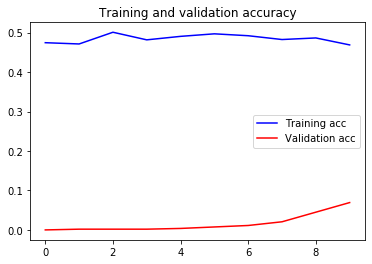

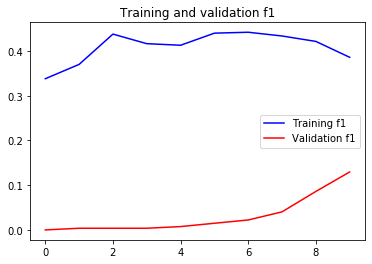

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [62]:
score = model.evaluate(X_test_sent_barasa, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 8us/step

f1: 0.0937499850988388
accuracy: 0.3729729652404785
LOSS: 0.6991908550262451


In [63]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test_sent_barasa, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test_sent_barasa, verbose=0)

In [64]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [65]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [66]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.372973
Precision: 0.750000
Recall: 0.050000
F1 score: 0.093750
Kappa score: 0.013787


Text(0.5, 15.0, 'Predicted')

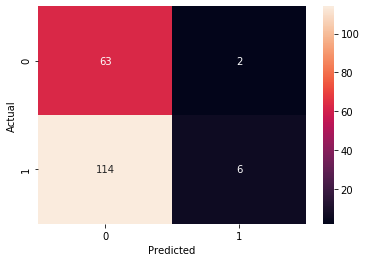

In [67]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 3. Barasa Sentiment Model + Cleaned Text

In [68]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [69]:
X_train_text_sent_barasa.shape

(1780, 104)

In [70]:
type(X_train_text_sent_barasa)

numpy.ndarray

In [71]:
# Reshaping X_train & X_test
X_train_text_sent_barasa = X_train_text_sent_barasa[:, :, None]
X_test_text_sent_barasa = X_test_text_sent_barasa[:, :, None]

In [72]:
X_train_text_sent_barasa.shape

(1780, 104, 1)

In [73]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, input_shape=X_train_text_sent_barasa.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [75]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train_text_sent_barasa, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1246 samples, validate on 534 samples
Epoch 1/10
1246/1246 [==============================] - 1s 556us/step - loss: 0.7095 - accuracy: 0.4735 - f1_m: 0.3368 - val_loss: 0.8248 - val_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/10
1246/1246 [==============================] - 0s 147us/step - loss: 0.7116 - accuracy: 0.4711 - f1_m: 0.3701 - val_loss: 0.8108 - val_accuracy: 0.0019 - val_f1_m: 0.0037
Epoch 3/10
1246/1246 [==============================] - 0s 147us/step - loss: 0.7039 - accuracy: 0.5008 - f1_m: 0.4379 - val_loss: 0.7972 - val_accuracy: 0.0019 - val_f1_m: 0.0037
Epoch 4/10
1246/1246 [==============================] - 0s 188us/step - loss: 0.7050 - accuracy: 0.4815 - f1_m: 0.4165 - val_loss: 0.7840 - val_accuracy: 0.0019 - val_f1_m: 0.0037
Epoch 5/10
1246/1246 [==============================] - 0s 128us/step - loss: 0.7023 - accuracy: 0.4904 - f1_m: 0.4129 - val_loss: 0.7714 - val_accuracy: 0.0037 - val_f1_m: 0.0075
Epoch 6/10
1246/1246 [=======================

In [76]:
save_model(model, 'model/LSTM cbow_text_sent_barasa')

Saved model to disk


In [77]:
history.history

{'val_loss': [0.8247950673103333,
  0.8107516169548035,
  0.7971799373626709,
  0.7840250134468079,
  0.771368682384491,
  0.759236752986908,
  0.7475501894950867,
  0.7361112833023071,
  0.725426435470581,
  0.7154433131217957],
 'val_accuracy': [0.0,
  0.00187265919521451,
  0.00187265919521451,
  0.00187265919521451,
  0.00374531839042902,
  0.009363295510411263,
  0.013108613900840282,
  0.03558052331209183,
  0.056179776787757874,
  0.11423221230506897],
 'val_f1_m': [0.0,
  0.0037383174058049917,
  0.0037383174058049917,
  0.0037383174058049917,
  0.00746268592774868,
  0.01855287328362465,
  0.025878001004457474,
  0.06871608644723892,
  0.10638297349214554,
  0.2050420045852661],
 'loss': [0.7094705777413198,
  0.7115922730003467,
  0.7038669198703613,
  0.705014141183795,
  0.7022616161963339,
  0.6996181094435971,
  0.6986404846797594,
  0.6979729629825818,
  0.6965605270231133,
  0.6980005909313551],
 'accuracy': [0.47351524,
  0.47110754,
  0.5008026,
  0.48154092,
  0.4903

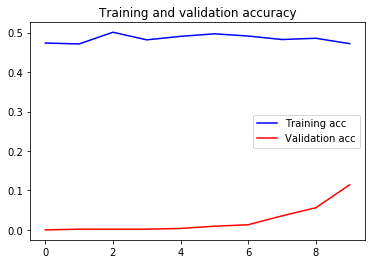

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [79]:
score = model.evaluate(X_test_text_sent_barasa, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 44us/step

f1: 0.16417907178401947
accuracy: 0.39459457993507385
LOSS: 0.6970992684364319


In [80]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test_text_sent_barasa, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test_text_sent_barasa, verbose=0)

In [81]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [82]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [83]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.394595
Precision: 0.785714
Recall: 0.091667
F1 score: 0.164179
Kappa score: 0.033131


Text(0.5, 15.0, 'Predicted')

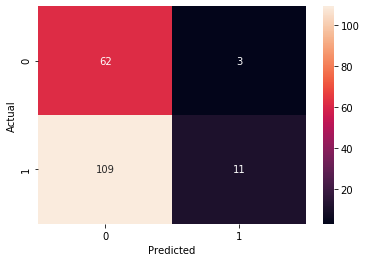

In [84]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 4. Trans Sentiment Model

In [85]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [86]:
X_train_sent_trans.shape

(1780, 4)

In [87]:
type(X_train_sent_trans)

pandas.core.frame.DataFrame

In [88]:
X_train_sent_trans = X_train_sent_trans.to_numpy()
X_test_sent_trans = X_test_sent_trans.to_numpy()

In [89]:
type(X_train_sent_trans)

numpy.ndarray

In [90]:
X_train_sent_trans.shape

(1780, 4)

In [91]:
# Reshaping X_train & X_test
X_train_sent_trans = X_train_sent_trans[:, :, None]
X_test_sent_trans = X_test_sent_trans[:, :, None]

In [92]:
X_train_sent_trans.shape

(1780, 4, 1)

In [93]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, input_shape=X_train_sent_trans.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [95]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train_sent_trans, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1246 samples, validate on 534 samples
Epoch 1/10
1246/1246 [==============================] - 1s 445us/step - loss: 0.7061 - accuracy: 0.4727 - f1_m: 0.3389 - val_loss: 0.7930 - val_accuracy: 0.0431 - val_f1_m: 0.0826
Epoch 2/10
1246/1246 [==============================] - 0s 11us/step - loss: 0.7078 - accuracy: 0.4864 - f1_m: 0.4002 - val_loss: 0.7821 - val_accuracy: 0.0993 - val_f1_m: 0.1806
Epoch 3/10
1246/1246 [==============================] - 0s 12us/step - loss: 0.7017 - accuracy: 0.5096 - f1_m: 0.4784 - val_loss: 0.7710 - val_accuracy: 0.1648 - val_f1_m: 0.2830
Epoch 4/10
1246/1246 [==============================] - 0s 12us/step - loss: 0.7036 - accuracy: 0.4952 - f1_m: 0.4677 - val_loss: 0.7602 - val_accuracy: 0.1835 - val_f1_m: 0.3101
Epoch 5/10
1246/1246 [==============================] - 0s 20us/step - loss: 0.6998 - accuracy: 0.5096 - f1_m: 0.4725 - val_loss: 0.7498 - val_accuracy: 0.2397 - val_f1_m: 0.3867
Epoch 6/10
1246/1246 [==============================] - 0

In [96]:
save_model(model, 'model/LSTM cbow_sent_trans')

Saved model to disk


In [97]:
history.history

{'val_loss': [0.7929844856262207,
  0.7821097373962402,
  0.7710303664207458,
  0.7602340579032898,
  0.749814510345459,
  0.7398826479911804,
  0.7304022908210754,
  0.7211944460868835,
  0.7127152681350708,
  0.7049195766448975],
 'val_accuracy': [0.043071161955595016,
  0.09925093501806259,
  0.16479401290416718,
  0.1835206001996994,
  0.23970037698745728,
  0.26404494047164917,
  0.2846441864967346,
  0.30524343252182007,
  0.32771536707878113,
  0.33707866072654724],
 'val_f1_m': [0.08258526772260666,
  0.18057920038700104,
  0.28295817971229553,
  0.31012657284736633,
  0.3867068886756897,
  0.41777774691581726,
  0.4431486129760742,
  0.4677187502384186,
  0.49365299940109253,
  0.5042016506195068],
 'loss': [0.7061293808262,
  0.7078490988209389,
  0.701673414695703,
  0.7036240431891208,
  0.6997852996111299,
  0.6990048922658157,
  0.6989674556695439,
  0.6979779542736219,
  0.6959012655921005,
  0.699194892355948],
 'accuracy': [0.47271267,
  0.48635635,
  0.5096308,
  0.49

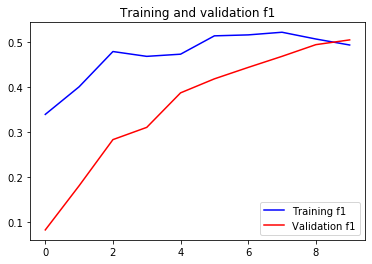

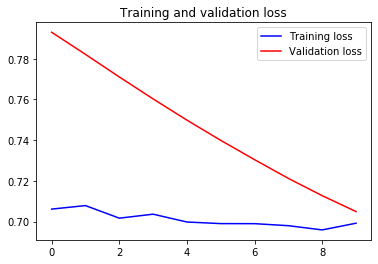

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [99]:
score = model.evaluate(X_test_sent_trans, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 8us/step

f1: 0.3046357035636902
accuracy: 0.4324324429035187
LOSS: 0.6977485418319702


In [100]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test_sent_trans, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test_sent_trans, verbose=0)

In [101]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [102]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [103]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.432432
Precision: 0.741935
Recall: 0.191667
F1 score: 0.304636
Kappa score: 0.052208


Text(0.5, 15.0, 'Predicted')

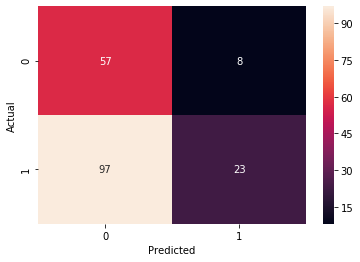

In [104]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### 5. Trans Sentiment Model + Cleaned Text

In [105]:
seed_value = 1
num = 38

# Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set tensorflow random seed
tf.random.set_seed(num)

In [106]:
X_train_text_sent_trans.shape

(1780, 104)

In [107]:
type(X_train_text_sent_trans)

numpy.ndarray

In [108]:
# Reshaping X_train & X_test
X_train_text_sent_trans = X_train_text_sent_trans[:, :, None]
X_test_text_sent_trans = X_test_text_sent_trans[:, :, None]

In [109]:
X_train_text_sent_barasa.shape

(1780, 104, 1)

In [110]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, input_shape=X_train_text_sent_trans.shape[1:]))
model.add(layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', f1_m])

In [112]:
EPOCHS = 10
BATCH_SIZE = 1024

history = model.fit(X_train_text_sent_trans, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    verbose=1)

Train on 1246 samples, validate on 534 samples
Epoch 1/10
1246/1246 [==============================] - 1s 555us/step - loss: 0.7062 - accuracy: 0.4751 - f1_m: 0.3462 - val_loss: 0.7928 - val_accuracy: 0.0431 - val_f1_m: 0.0826
Epoch 2/10
1246/1246 [==============================] - 0s 147us/step - loss: 0.7078 - accuracy: 0.4864 - f1_m: 0.4002 - val_loss: 0.7808 - val_accuracy: 0.1067 - val_f1_m: 0.1929
Epoch 3/10
1246/1246 [==============================] - 0s 155us/step - loss: 0.7015 - accuracy: 0.5136 - f1_m: 0.4834 - val_loss: 0.7691 - val_accuracy: 0.1685 - val_f1_m: 0.2885
Epoch 4/10
1246/1246 [==============================] - 0s 129us/step - loss: 0.7034 - accuracy: 0.4960 - f1_m: 0.4758 - val_loss: 0.7576 - val_accuracy: 0.2135 - val_f1_m: 0.3519
Epoch 5/10
1246/1246 [==============================] - 0s 154us/step - loss: 0.6995 - accuracy: 0.5120 - f1_m: 0.4806 - val_loss: 0.7466 - val_accuracy: 0.2491 - val_f1_m: 0.3988
Epoch 6/10
1246/1246 [==============================]

In [113]:
save_model(model, 'model/LSTM cbow_text_sent_trans')

Saved model to disk


In [114]:
history.history

{'val_loss': [0.7927564978599548,
  0.780849039554596,
  0.7690699100494385,
  0.7575755715370178,
  0.7465971112251282,
  0.7361257076263428,
  0.7260392308235168,
  0.716353178024292,
  0.7075433731079102,
  0.6994462013244629],
 'val_accuracy': [0.043071161955595016,
  0.10674156993627548,
  0.16853933036327362,
  0.21348313987255096,
  0.2490636706352234,
  0.26966291666030884,
  0.2996254563331604,
  0.3258427083492279,
  0.33707866072654724,
  0.35580524802207947],
 'val_f1_m': [0.08258526772260666,
  0.192893385887146,
  0.2884615361690521,
  0.35185182094573975,
  0.3988005816936493,
  0.42477869987487793,
  0.46109503507614136,
  0.4915253818035126,
  0.5042016506195068,
  0.5248618125915527],
 'loss': [0.7062142304777143,
  0.7077889889239499,
  0.7015300386407403,
  0.7033600789968696,
  0.6994668953300096,
  0.6986368861091271,
  0.698534639650899,
  0.6975555510811783,
  0.6955691773091618,
  0.6986618979593341],
 'accuracy': [0.4751204,
  0.48635635,
  0.5136437,
  0.4959

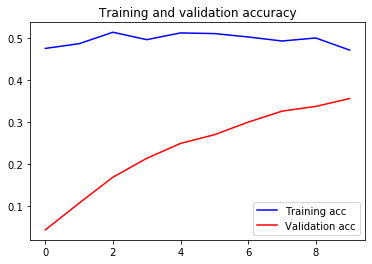

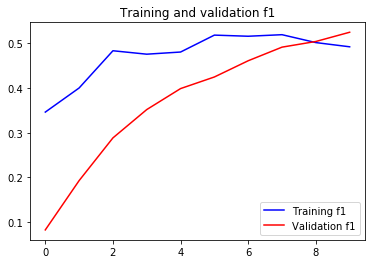

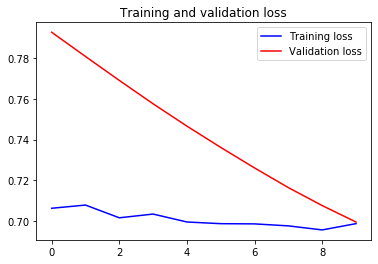

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, f1, 'b', label='Training f1')
plt.plot(epochs, val_f1, 'r', label='Validation f1')
plt.title('Training and validation f1')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [116]:
score = model.evaluate(X_test_text_sent_trans, y_test, batch_size=BATCH_SIZE)
print()
print("f1:",score[2])
print("accuracy:",score[1])
print("LOSS:",score[0])

185/185 [==============================] - 0s 45us/step

f1: 0.3376622796058655
accuracy: 0.4486486613750458
LOSS: 0.696010172367096


In [117]:
# predict probabilities for val set
y_pred_probs = model.predict(X_test_text_sent_trans, verbose=0)
# predict crisp classes for val set
y_pred = model.predict_classes(X_test_text_sent_trans, verbose=0)

In [118]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [119]:
# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]

In [120]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='binary')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Kappa score: %f' % kappa)

Accuracy: 0.448649
Precision: 0.764706
Recall: 0.216667
F1 score: 0.337662
Kappa score: 0.071815


Text(0.5, 15.0, 'Predicted')

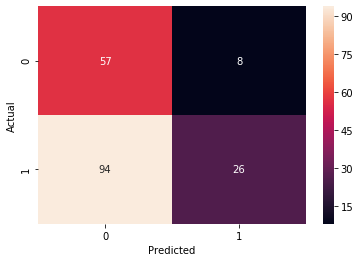

In [121]:
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')